In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as sps
import scipy.special
import scipy.integrate as integrate
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import random
import math
import time
from tqdm import tqdm

## Tasks 1

Функция генерации выборки с первой практики

In [2]:
def generate_n_random_numbers(N: int, distribution: str):
    """
    N - size of sample
    distribution - ["Uniform[0, 1]", "Uniform[-1, 1]", "2xUniform[-1, 1]", "3xUniform[-1, 1]", "Cauchy(0, 1)", Norm(0, 1)]
    """
    match distribution:
        case "Uniform[0, 1]":
            return [random.uniform(0, 1) for _ in range(N)]
        case "Uniform[-1, 1]":
            return [random.uniform(0, 1) * 2 - 1 for _ in range(N)]
        case "2xUniform[-1, 1]":
            t = generate_n_random_numbers(2 * N, "Uniform[-1, 1]")
            return [t[2 * i] + t[2 * i + 1] for i in range(N)]
        case "3xUniform[-1, 1]":
            t = generate_n_random_numbers(3 * N, "Uniform[-1, 1]")
            return [t[3 * i] + t[3 * i + 1] + t[3 * i + 2] for i in range(N)]
        case "Cauchy(0, 1)":
            t = generate_n_random_numbers(N, "Uniform[0, 1]")
            return list(map(lambda x: math.tan(math.pi * (x - 0.5)), t))
        case "Norm(0, 1)":
            return [random.normalvariate(0, 1) for _ in range(N)]
        case _:
            return []

In [68]:
P = 0.95
PERCENTILE = ((1 - P) / 2) * 100
norm_quantile = sps.norm(loc=0, scale=1).ppf((1 + P) / 2)
ANALYTICAL_EXPECTATION = 0
ANALYTICAL_MEDIAN = 0
ITERATIONS = 10 ** 3
BOOTSTRAP_SIZE = 1000
# NS = [10, 100, 500]
min_sample_size = 10
max_sample_size = 500
num_of_sample_sizes = 3
BASE = 5
# NS = list(map(int, np.linspace(min_sample_size, max_sample_size, num_of_sample_sizes)))
NS = list(map(int, np.logspace(base=BASE, start=math.log(min_sample_size, BASE), stop=math.log(max_sample_size, BASE), num=num_of_sample_sizes)))
print(NS)

[10, 70, 500]


Функции подсчёта доверительного интервала для квантили (или медианы при $p=0,5$) точно (через формулу Бернулли) и приближённо (по локальной теореме Муавра-Лапласа)

In [59]:
def bernoulli_coef(n: int, m: int, p: float) -> float:
    return sps.binom.pmf(m, n, p)

def quantil_confidence_interval_exact(sample: list, p=0.5) -> tuple:
    sample = sorted(sample)
    n = len(sample)
    prob = (1 - P) / 2
    m_1 = -1
    cum_sum_1 = 0
    while True:
        next_coef = bernoulli_coef(n, m_1 + 1, p)
        if cum_sum_1 + next_coef > prob:
            break
        cum_sum_1 += next_coef
        m_1 += 1
    m_2 = n + 1
    cum_sum_2 = 0
    while True:
        next_coef = bernoulli_coef(n, m_2 - 1, p)
        if cum_sum_2 + next_coef > prob:
            break
        cum_sum_2 += next_coef
        m_2 -= 1
    # m_2 = min(m_2, n - 1)  # because can't be n
    # print(f"m_1 = {m_1}, m_2 = {m_2}")
    # if 0 <= m_1 < n and 0 <= m_2 < n:
    #     print(f"return sample[{m_1}] = {sample[m_1]:.3f} and sample[{m_2}] = {sample[m_2]:.3f} as quantile x_{p} (sample length = {n})")
    # else:
    #     print(f"ERROR: can't return sample[{m_1}] or sample[{m_2}] as quantile x_{p} (sample length = {n})")
    return (sample[m_1] if m_1 >= 0 else -np.inf, sample[m_2] if m_2 <= n - 1 else np.inf)
    

In [60]:
def quantil_confidence_interval_approx(sample: list, p=0.5) -> tuple:
    sample = sorted(sample)
    n = len(sample)
    term = math.sqrt(n * p * (1 - p)) * norm_quantile
    m_1, m_2 = math.floor(n * p - term), math.ceil(n * p + term)
    # m_2 = min(m_2, n - 1)
    # print(f"return sample[{m_1}] = {sample[m_1]:.3f} and sample[{m_2}] = {sample[m_2]:.3f} as quantile x_{p} (sample length = {n})")
    return (sample[m_1] if m_1 >= 0 else -np.inf, sample[m_2] if m_2 <= n - 1 else np.inf)

Сгенерируем по $10^4$ выборок разных размеров для каждого распределения и проверим, какая доля из них будет попадать в доверительный интервал для медианы, посчитав доверительный интервал для этой доли

In [64]:
distros = ["Uniform[-1, 1]", "Norm(0, 1)", "2xUniform[-1, 1]"]
methods = ["exact", "approx", "ref"]
NUM_METHODS = len(methods)
methods_functions = {"exact": quantil_confidence_interval_exact, "approx": quantil_confidence_interval_approx}
sigma_squared = {"Uniform[-1, 1]": 1 / 3,
                 "Norm(0, 1)": 1,
                 "2xUniform[-1, 1]": 2 / 3}

In [69]:
print("Start generating samples...")
samples = {d: [[generate_n_random_numbers(n, d) for _ in range(ITERATIONS)]
                for n in NS] for d in tqdm(distros)}
print("Samples generated.")

Start generating samples...


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

Samples generated.


In [73]:
results = {d: {m + g: [] for m in methods for g in ['_intervals', '_points']} for d in distros}
total_time = {m: 0 for m in methods}
for i, d in enumerate(distros):
    for n_id, n in enumerate(NS):
        print(f"Distribution {d}, samples size = {n}")
        for method in methods:
            hits_counter = 0
            start_time = time.time()
            for sample in samples[d][n_id]:
                if method != "ref":
                    d_left, d_right = methods_functions[method](sample=sample, p=0.5)
                    hits_counter += d_left <= ANALYTICAL_MEDIAN <= d_right
                else:
                    ref_interval = sps.quantile_test(sample, p=0.5).confidence_interval()
                    hits_counter += ref_interval[0] <= ANALYTICAL_MEDIAN <= ref_interval[1]
            total_time[method] += time.time() - start_time
            results[d][method + "_intervals"].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
            results[d][method + "_points"].append(hits_counter / ITERATIONS)


    print(f"Results for distribution {d}\n"
            f"{results[d]['exact_intervals']} (exact)\n"
            f"{results[d]['approx_intervals']} (approx)\n"
            f"{results[d]['ref_intervals']} (ref)\n")

for method in methods:
    print(f"{method.capitalize()} method took {total_time[method]:.2f} seconds, ")


Distribution Uniform[-1, 1], samples size = 10
Distribution Uniform[-1, 1], samples size = 70
Distribution Uniform[-1, 1], samples size = 500
Results for distribution Uniform[-1, 1]
[(0.9878326041120653, 0.9981673958879347), (0.950149752380254, 0.9738502476197459), (0.9605994404510177, 0.9814005595489822)] (exact)
[(0.9878326041120653, 0.9981673958879347), (0.950149752380254, 0.9738502476197459), (0.947854547405936, 0.9721454525940639)] (approx)
[(0.9762231158120357, 0.9917768841879643), (0.9387508754149401, 0.9652491245850598), (0.9547675081345732, 0.9772324918654267)] (ref)

Distribution Norm(0, 1), samples size = 10
Distribution Norm(0, 1), samples size = 70
Distribution Norm(0, 1), samples size = 500
Results for distribution Norm(0, 1)
[(0.9689086399264986, 0.9870913600735014), (0.9617750724567843, 0.9822249275432157), (0.9421513933510544, 0.9678486066489456)] (exact)
[(0.9689086399264986, 0.9870913600735014), (0.9617750724567843, 0.9822249275432157), (0.9364918804423794, 0.9635081

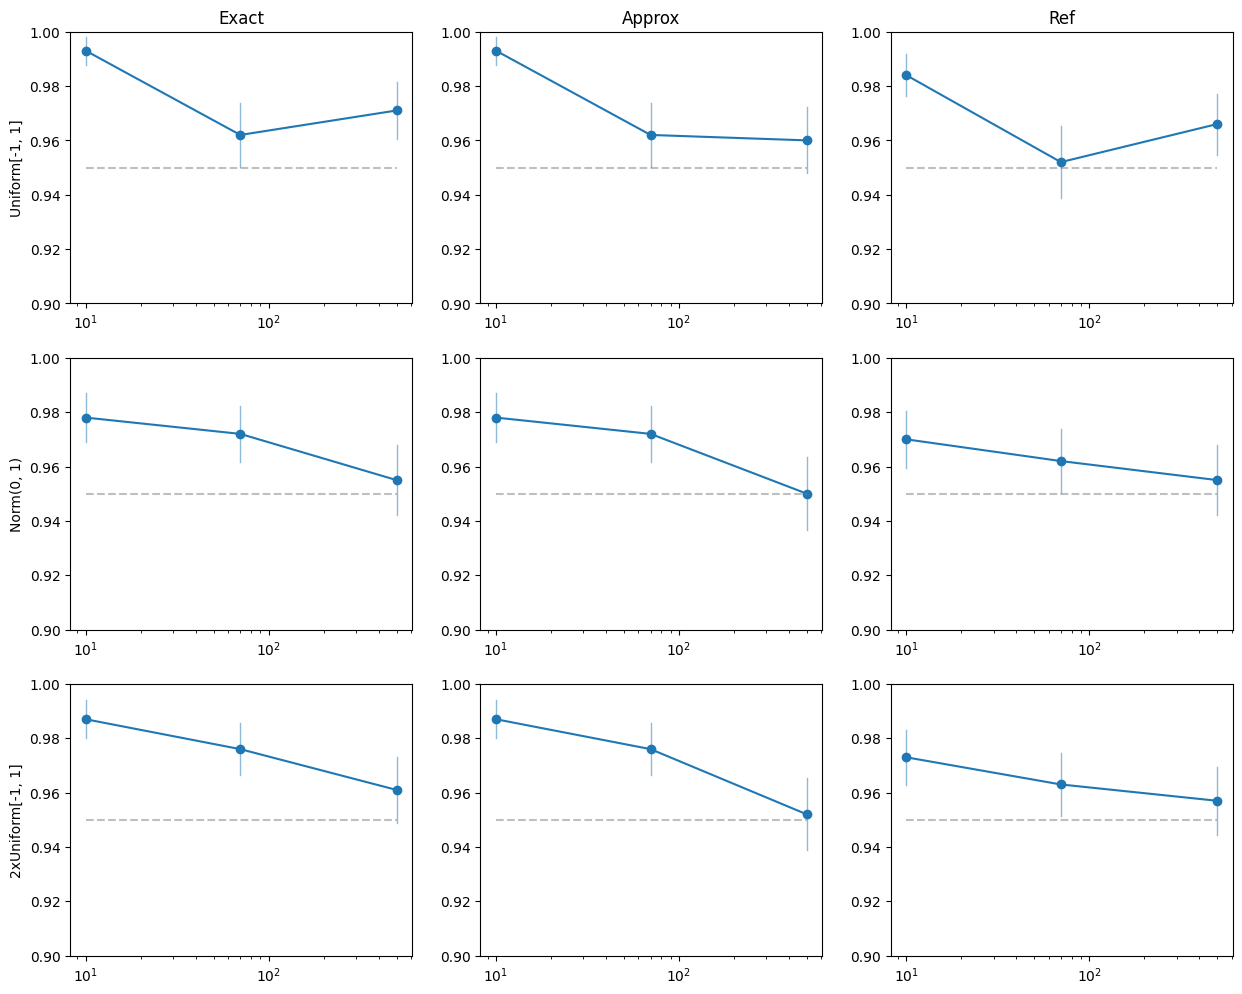

In [74]:
_, axis = plt.subplots(3, NUM_METHODS, figsize=(5 * NUM_METHODS, 4 * len(distros)))
for i, d in enumerate(distros):
    for method_id, method in enumerate(methods):
        for interval_id, interval in enumerate(results[d][method + "_intervals"]):
            axis[i][method_id].plot([NS[interval_id]] * 2, list(interval), color='C0', alpha=.5, linewidth=1)

        axis[i][method_id].plot(NS, results[d][method + "_points"], '-o', color='C0', alpha=1)         
        axis[i][method_id].plot(NS, [0.95] * len(NS), color='gray', alpha=.5, linestyle='--')         
        axis[i][method_id].set_xscale('log')
        axis[i][method_id].set_ylim([0.9, 1])
        axis[0][method_id].title.set_text(method.capitalize())
    axis[i][0].set_ylabel(d)

plt.show()

## Task 2

Теперь сделаем то же самое, но с доверительными интервалами не для медианы, а квантилей $x_{0.01}$ и $x_{0.99}$

In [75]:
QUANTILES = [0.01, 0.5, 0.99]

Для того чтобы оценить, сколько доверительных интервалов на самом деле содержат реальные квантили, нужно их сначала найти для наших распределений. 

Это легко сделать для стандартных распределений $\text{Uniform}[-1, 1]$ и $\text{Norm}(0, 1)$, но несколько сложнее для $2\cdot\text{Uniform}[-1, 1]$. Для первых двух воспользуемся стандартной функцией, а для последнего напишем бинпоиск по функции распределения, поскольку она монотонна. Чтобы найти функцию распределения, проинтегрируем свёртку плотностей равномерных распределений, то есть
$$\xi, \eta \sim \text{Uniform[-1, 1]}$$
$$F_{\xi + \eta}(t) = \int_{-\infty}^t p_{\xi + \eta}(x) dx = \int_{-\infty}^t \int_{\mathbb{R}} p_\xi(y)\cdot p_\eta(x-y)dy dx$$
Внутренний интеграл легко посчитать и аналитически записать полученную функцию. Итого можем посчитать функцию распределения суммы двух равномерных распределений:

In [11]:
def sum_pdf(t: float) -> float:
    if t <= -2 or t >= 2:
        return 0
    if -2 < t <= 0:
        return (2 + t) / 4
    return (2 - t) / 4

def sum_cdf(t):
    return integrate.quad(sum_pdf, -np.inf, t)[0]

def sum_quantile(p, lo=-2, hi=2):
    val_range = [lo, hi]
    k = 0.5 * sum(val_range)
    for _ in range(32):
        val_range[int(sum_cdf(k) > p)] = k
        next_k = 0.5 * sum(val_range)
        if next_k == k:
            break
        k = next_k
    return k

In [76]:
QUANTILE_VALUES = {d: dict() for d in distros}
QUANTILE_VALUES["Uniform[-1, 1]"] = [sps.uniform.ppf(q, loc=-1, scale=2) for q in QUANTILES]
QUANTILE_VALUES["Norm(0, 1)"] = [sps.norm.ppf(q) for q in QUANTILES]
QUANTILE_VALUES["2xUniform[-1, 1]"] = [sum_quantile(q) for q in QUANTILES]

Визуализируем для наглядности полученный результат

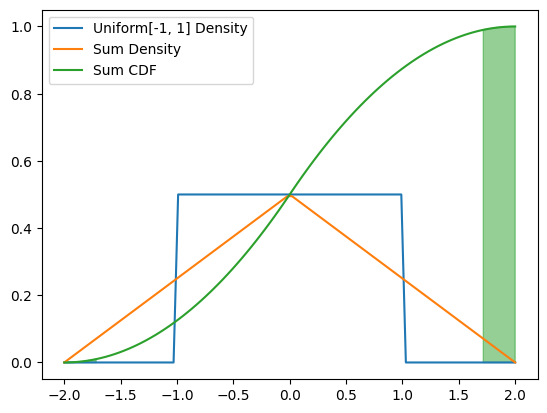

In [13]:
x = np.linspace(-2, 2, 100)
y1 = sps.uniform.pdf(x, loc=-1, scale=2)
y2 = [sum_pdf(t) for t in x]
y3 = [sum_cdf(t) for t in x]
    
plt.plot(x, y1, label='Uniform[-1, 1] Density')
plt.plot(x, y2, label='Sum Density')
plt.plot(x, y3, label='Sum CDF')
plt.fill_between(x, y3, where = (x > QUANTILE_VALUES["2xUniform[-1, 1]"][1]) | (x < QUANTILE_VALUES["2xUniform[-1, 1]"][0]), color='C2', alpha=0.5)
plt.legend()
plt.show()

In [77]:
print(QUANTILE_VALUES)

{'Uniform[-1, 1]': [np.float64(-0.98), np.float64(0.0), np.float64(0.98)], 'Norm(0, 1)': [np.float64(-2.3263478740408408), np.float64(0.0), np.float64(2.3263478740408408)], '2xUniform[-1, 1]': [-1.7171573103405535, -4.656612873077393e-10, 1.7171572870574892]}


Теперь приступим к подсчёту доверительных интервалов для квантилей по нашим выборкам

In [52]:
results = {d: [{"exact_intervals": [], "exact_points": [], "approx_intervals": [], "approx_points": []},
               {"exact_intervals": [], "exact_points": [], "approx_intervals": [], "approx_points": []}]
               for d in distros}
includes_edges = {d: np.zeros((len(methods),len(QUANTILES), len(NS))) for d in distros}
for i, d in enumerate(distros):
    for n_id, n in enumerate(NS):
        print(f"Distribution {d}, samples size = {n}")
        for method_id, method in enumerate(methods):
            for p_id, p in enumerate(QUANTILES):
                hits_counter = 0
                includes_edges_counter = 0
                start_time = time.time()
                for sample in tqdm(samples[d][n_id]):
                    d_left, d_right = methods_functions[method](sample=sample, p=p)
                    hits_counter += d_left <= QUANTILE_VALUES[d][p_id] <= d_right
                    ref_interval = sps.quantile_test(sample, p=p).confidence_interval()
                    print(f"My result: [{d_left:.3f}, {d_right:.3f}] compared to\nref result [{ref_interval[0]:.3f}, {ref_interval[1]:.3f}]")
                    if p < 0.5:  # x_0.01
                        if d_left <= min(sample) <= d_right:
                            includes_edges_counter += 1
                        print(f"First 10 elements of sample: [", end='')
                        for el in sorted(sample)[0:10]:
                            print(f"{el:.3f}, ", end='')
                        print("...]\n")
                    else:  # x_0.99
                        if d_left <= max(sample) <= d_right:
                            includes_edges_counter += 1
                        print(f"Last 10 elements of sample: [..., ", end='')
                        for el in sorted(sample)[-10:]:
                            print(f"{el:.3f}, ", end='')
                        print("]\n")
                includes_edges[d][method_id][p_id][n_id] = includes_edges_counter / ITERATIONS
                # print(results[d][p_id][method + "_intervals"])
                results[d][p_id][method + "_intervals"].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
                results[d][p_id][method + "_points"].append(hits_counter / ITERATIONS)
        print('-' * 100)
    print('=' * 100, '\n', '-' * 100, sep='')

Distribution Uniform[-1, 1], samples size = 100


 13%|█▎        | 13/100 [00:00<00:00, 126.62it/s]

My result: [-0.973, -0.892] compared to
ref result [nan, -0.931]
First 10 elements of sample: [-0.973, -0.968, -0.932, -0.931, -0.892, -0.857, -0.810, -0.803, -0.773, -0.722, ...]

My result: [-0.988, -0.926] compared to
ref result [nan, -0.940]
First 10 elements of sample: [-0.988, -0.965, -0.954, -0.940, -0.926, -0.898, -0.880, -0.875, -0.860, -0.844, ...]

My result: [-0.951, -0.933] compared to
ref result [nan, -0.935]
First 10 elements of sample: [-0.951, -0.937, -0.936, -0.935, -0.933, -0.896, -0.896, -0.890, -0.876, -0.873, ...]

My result: [-0.995, -0.857] compared to
ref result [nan, -0.943]
First 10 elements of sample: [-0.995, -0.952, -0.946, -0.943, -0.857, -0.847, -0.837, -0.789, -0.785, -0.761, ...]

My result: [-0.994, -0.868] compared to
ref result [nan, -0.884]
First 10 elements of sample: [-0.994, -0.991, -0.911, -0.884, -0.868, -0.852, -0.841, -0.808, -0.741, -0.695, ...]

My result: [-0.991, -0.956] compared to
ref result [nan, -0.962]
First 10 elements of sample: [

 29%|██▉       | 29/100 [00:00<00:00, 138.10it/s]

My result: [-0.991, -0.897] compared to
ref result [nan, -0.910]
First 10 elements of sample: [-0.991, -0.919, -0.911, -0.910, -0.897, -0.887, -0.871, -0.848, -0.844, -0.831, ...]

My result: [-0.983, -0.882] compared to
ref result [nan, -0.903]
First 10 elements of sample: [-0.983, -0.947, -0.943, -0.903, -0.882, -0.870, -0.842, -0.831, -0.822, -0.780, ...]

My result: [-0.997, -0.935] compared to
ref result [nan, -0.954]
First 10 elements of sample: [-0.997, -0.985, -0.984, -0.954, -0.935, -0.850, -0.825, -0.803, -0.787, -0.764, ...]

My result: [-0.983, -0.855] compared to
ref result [nan, -0.868]
First 10 elements of sample: [-0.983, -0.965, -0.951, -0.868, -0.855, -0.825, -0.787, -0.781, -0.780, -0.779, ...]

My result: [-0.991, -0.906] compared to
ref result [nan, -0.909]
First 10 elements of sample: [-0.991, -0.922, -0.916, -0.909, -0.906, -0.836, -0.810, -0.770, -0.726, -0.725, ...]

My result: [-0.986, -0.969] compared to
ref result [nan, -0.971]
First 10 elements of sample: [

 59%|█████▉    | 59/100 [00:00<00:00, 129.02it/s]

My result: [-0.966, -0.913] compared to
ref result [nan, -0.919]
First 10 elements of sample: [-0.966, -0.954, -0.945, -0.919, -0.913, -0.903, -0.893, -0.886, -0.882, -0.881, ...]

My result: [-0.992, -0.955] compared to
ref result [nan, -0.970]
First 10 elements of sample: [-0.992, -0.987, -0.979, -0.970, -0.955, -0.955, -0.881, -0.875, -0.871, -0.868, ...]

My result: [-0.995, -0.875] compared to
ref result [nan, -0.928]
First 10 elements of sample: [-0.995, -0.979, -0.930, -0.928, -0.875, -0.840, -0.838, -0.822, -0.810, -0.753, ...]

My result: [-0.996, -0.961] compared to
ref result [nan, -0.986]
First 10 elements of sample: [-0.996, -0.996, -0.991, -0.986, -0.961, -0.953, -0.912, -0.898, -0.875, -0.841, ...]

My result: [-0.950, -0.884] compared to
ref result [nan, -0.908]
First 10 elements of sample: [-0.950, -0.910, -0.908, -0.908, -0.884, -0.883, -0.871, -0.871, -0.849, -0.822, ...]

My result: [-0.996, -0.929] compared to
ref result [nan, -0.939]
First 10 elements of sample: [

 85%|████████▌ | 85/100 [00:00<00:00, 113.04it/s]

My result: [-0.997, -0.856] compared to
ref result [nan, -0.971]
First 10 elements of sample: [-0.997, -0.997, -0.990, -0.971, -0.856, -0.853, -0.843, -0.824, -0.824, -0.771, ...]

My result: [-0.994, -0.926] compared to
ref result [nan, -0.931]
First 10 elements of sample: [-0.994, -0.967, -0.961, -0.931, -0.926, -0.918, -0.905, -0.891, -0.890, -0.827, ...]

My result: [-0.994, -0.862] compared to
ref result [nan, -0.876]
First 10 elements of sample: [-0.994, -0.968, -0.949, -0.876, -0.862, -0.831, -0.818, -0.816, -0.806, -0.798, ...]

My result: [-0.981, -0.809] compared to
ref result [nan, -0.910]
First 10 elements of sample: [-0.981, -0.953, -0.928, -0.910, -0.809, -0.786, -0.757, -0.751, -0.737, -0.730, ...]

My result: [-0.974, -0.938] compared to
ref result [nan, -0.939]
First 10 elements of sample: [-0.974, -0.966, -0.964, -0.939, -0.938, -0.933, -0.880, -0.847, -0.793, -0.791, ...]

My result: [-0.999, -0.880] compared to
ref result [nan, -0.971]
First 10 elements of sample: [

 29%|██▉       | 29/100 [00:00<00:00, 141.00it/s]

My result: [0.958, 0.976] compared to
ref result [0.958, nan]
Last 10 elements of sample: [..., 0.855, 0.859, 0.863, 0.864, 0.885, 0.911, 0.958, 0.965, 0.974, 0.976, ]

My result: [0.966, 0.994] compared to
ref result [0.966, nan]
Last 10 elements of sample: [..., 0.841, 0.862, 0.882, 0.894, 0.904, 0.965, 0.966, 0.981, 0.992, 0.994, ]

My result: [0.872, 0.979] compared to
ref result [0.872, nan]
Last 10 elements of sample: [..., 0.765, 0.774, 0.812, 0.818, 0.826, 0.836, 0.872, 0.884, 0.896, 0.979, ]

My result: [0.920, 0.961] compared to
ref result [0.920, nan]
Last 10 elements of sample: [..., 0.841, 0.845, 0.856, 0.901, 0.913, 0.914, 0.920, 0.951, 0.955, 0.961, ]

My result: [0.981, 0.999] compared to
ref result [0.981, nan]
Last 10 elements of sample: [..., 0.836, 0.884, 0.922, 0.935, 0.942, 0.942, 0.981, 0.982, 0.993, 0.999, ]

My result: [0.878, 0.986] compared to
ref result [0.878, nan]
Last 10 elements of sample: [..., 0.727, 0.736, 0.754, 0.775, 0.834, 0.850, 0.878, 0.962, 0.9

 44%|████▍     | 44/100 [00:00<00:00, 118.79it/s]

My result: [0.968, 0.994] compared to
ref result [0.968, nan]
Last 10 elements of sample: [..., 0.815, 0.851, 0.878, 0.895, 0.918, 0.949, 0.968, 0.971, 0.982, 0.994, ]

My result: [0.903, 0.975] compared to
ref result [0.903, nan]
Last 10 elements of sample: [..., 0.789, 0.831, 0.843, 0.860, 0.876, 0.890, 0.903, 0.921, 0.931, 0.975, ]

My result: [0.939, 0.997] compared to
ref result [0.939, nan]
Last 10 elements of sample: [..., 0.775, 0.812, 0.814, 0.852, 0.859, 0.878, 0.939, 0.967, 0.979, 0.997, ]

My result: [0.893, 0.970] compared to
ref result [0.893, nan]
Last 10 elements of sample: [..., 0.741, 0.766, 0.809, 0.832, 0.834, 0.891, 0.893, 0.908, 0.936, 0.970, ]

My result: [0.965, 0.998] compared to
ref result [0.965, nan]
Last 10 elements of sample: [..., 0.825, 0.830, 0.871, 0.923, 0.936, 0.940, 0.965, 0.969, 0.982, 0.998, ]

My result: [0.971, 0.995] compared to
ref result [0.971, nan]
Last 10 elements of sample: [..., 0.861, 0.914, 0.915, 0.937, 0.957, 0.967, 0.971, 0.982, 0.9

 70%|███████   | 70/100 [00:00<00:00, 110.97it/s]

My result: [0.869, 0.943] compared to
ref result [0.869, nan]
Last 10 elements of sample: [..., 0.781, 0.781, 0.805, 0.843, 0.856, 0.868, 0.869, 0.892, 0.931, 0.943, ]

My result: [0.937, 0.985] compared to
ref result [0.937, nan]
Last 10 elements of sample: [..., 0.784, 0.786, 0.808, 0.851, 0.889, 0.928, 0.937, 0.942, 0.951, 0.985, ]

My result: [0.950, 0.974] compared to
ref result [0.950, nan]
Last 10 elements of sample: [..., 0.670, 0.696, 0.749, 0.761, 0.788, 0.873, 0.950, 0.957, 0.961, 0.974, ]

My result: [0.947, 0.993] compared to
ref result [0.947, nan]
Last 10 elements of sample: [..., 0.818, 0.824, 0.827, 0.832, 0.887, 0.937, 0.947, 0.982, 0.987, 0.993, ]

My result: [0.937, 0.976] compared to
ref result [0.937, nan]
Last 10 elements of sample: [..., 0.875, 0.901, 0.901, 0.912, 0.925, 0.928, 0.937, 0.945, 0.963, 0.976, ]

My result: [0.981, 0.999] compared to
ref result [0.981, nan]
Last 10 elements of sample: [..., 0.877, 0.896, 0.928, 0.947, 0.959, 0.980, 0.981, 0.990, 0.9

100%|██████████| 100/100 [00:00<00:00, 122.51it/s]


My result: [0.898, 0.964] compared to
ref result [0.898, nan]
Last 10 elements of sample: [..., 0.849, 0.870, 0.886, 0.890, 0.892, 0.894, 0.898, 0.913, 0.936, 0.964, ]

My result: [0.935, 0.982] compared to
ref result [0.935, nan]
Last 10 elements of sample: [..., 0.695, 0.704, 0.740, 0.786, 0.921, 0.935, 0.935, 0.965, 0.973, 0.982, ]

My result: [0.966, 0.988] compared to
ref result [0.966, nan]
Last 10 elements of sample: [..., 0.776, 0.781, 0.811, 0.902, 0.910, 0.957, 0.966, 0.966, 0.987, 0.988, ]

My result: [0.966, 0.995] compared to
ref result [0.966, nan]
Last 10 elements of sample: [..., 0.800, 0.802, 0.819, 0.834, 0.840, 0.920, 0.966, 0.986, 0.989, 0.995, ]

My result: [0.919, 0.986] compared to
ref result [0.919, nan]
Last 10 elements of sample: [..., 0.873, 0.889, 0.899, 0.903, 0.905, 0.911, 0.919, 0.925, 0.973, 0.986, ]

My result: [0.919, 0.985] compared to
ref result [0.919, nan]
Last 10 elements of sample: [..., 0.810, 0.833, 0.834, 0.911, 0.915, 0.917, 0.919, 0.947, 0.9

  0%|          | 0/100 [00:00<?, ?it/s]

My result: [-2.097, -1.581] compared to
ref result [nan, -1.593]
First 10 elements of sample: [-2.097, -1.706, -1.609, -1.593, -1.581, -1.432, -1.426, -1.319, -1.255, -1.120, ...]

My result: [-2.246, -1.817] compared to
ref result [nan, -1.885]
First 10 elements of sample: [-2.246, -2.235, -2.086, -1.885, -1.817, -1.802, -1.747, -1.729, -1.472, -1.424, ...]

My result: [-2.089, -1.504] compared to
ref result [nan, -1.507]
First 10 elements of sample: [-2.089, -1.588, -1.547, -1.507, -1.504, -1.477, -1.453, -1.394, -1.152, -1.079, ...]

My result: [-2.508, -1.427] compared to
ref result [nan, -1.765]
First 10 elements of sample: [-2.508, -2.247, -2.160, -1.765, -1.427, -1.331, -1.313, -1.251, -1.207, -1.168, ...]

My result: [-2.887, -1.772] compared to
ref result [nan, -1.938]
First 10 elements of sample: [-2.887, -2.321, -2.191, -1.938, -1.772, -1.706, -1.554, -1.474, -1.460, -1.390, ...]

My result: [-2.243, -1.555] compared to
ref result [nan, -1.879]
First 10 elements of sample: [

 29%|██▉       | 29/100 [00:00<00:00, 137.32it/s]

My result: [-2.501, -1.717] compared to
ref result [nan, -1.799]
First 10 elements of sample: [-2.501, -2.031, -1.931, -1.799, -1.717, -1.687, -1.607, -1.594, -1.576, -1.485, ...]

My result: [-2.346, -1.649] compared to
ref result [nan, -1.725]
First 10 elements of sample: [-2.346, -2.003, -1.781, -1.725, -1.649, -1.517, -1.407, -1.355, -1.266, -1.194, ...]

My result: [-1.908, -1.486] compared to
ref result [nan, -1.490]
First 10 elements of sample: [-1.908, -1.878, -1.754, -1.490, -1.486, -1.426, -1.360, -1.353, -1.268, -1.223, ...]

My result: [-2.187, -1.868] compared to
ref result [nan, -1.967]
First 10 elements of sample: [-2.187, -1.996, -1.984, -1.967, -1.868, -1.678, -1.658, -1.581, -1.568, -1.542, ...]

My result: [-2.174, -1.496] compared to
ref result [nan, -1.742]
First 10 elements of sample: [-2.174, -2.062, -1.842, -1.742, -1.496, -1.470, -1.462, -1.421, -1.283, -1.215, ...]

My result: [-2.331, -1.519] compared to
ref result [nan, -1.583]
First 10 elements of sample: [

 57%|█████▋    | 57/100 [00:00<00:00, 131.34it/s]

My result: [-1.947, -1.605] compared to
ref result [nan, -1.636]
First 10 elements of sample: [-1.947, -1.731, -1.637, -1.636, -1.605, -1.460, -1.393, -1.334, -1.277, -1.273, ...]

My result: [-2.432, -1.859] compared to
ref result [nan, -1.953]
First 10 elements of sample: [-2.432, -2.046, -2.019, -1.953, -1.859, -1.770, -1.656, -1.541, -1.444, -1.334, ...]

My result: [-2.767, -1.526] compared to
ref result [nan, -1.767]
First 10 elements of sample: [-2.767, -2.482, -1.812, -1.767, -1.526, -1.463, -1.460, -1.385, -1.287, -1.199, ...]

My result: [-1.919, -1.455] compared to
ref result [nan, -1.480]
First 10 elements of sample: [-1.919, -1.820, -1.546, -1.480, -1.455, -1.395, -1.238, -1.126, -1.117, -1.049, ...]

My result: [-2.385, -1.487] compared to
ref result [nan, -1.922]
First 10 elements of sample: [-2.385, -2.065, -1.993, -1.922, -1.487, -1.412, -1.351, -1.338, -1.330, -1.318, ...]

My result: [-1.708, -1.232] compared to
ref result [nan, -1.373]
First 10 elements of sample: [

 84%|████████▍ | 84/100 [00:00<00:00, 122.86it/s]

My result: [-2.808, -2.052] compared to
ref result [nan, -2.103]
First 10 elements of sample: [-2.808, -2.579, -2.265, -2.103, -2.052, -1.935, -1.640, -1.492, -1.401, -1.378, ...]

My result: [-1.897, -1.552] compared to
ref result [nan, -1.652]
First 10 elements of sample: [-1.897, -1.821, -1.671, -1.652, -1.552, -1.487, -1.464, -1.402, -1.162, -1.158, ...]

My result: [-2.022, -1.093] compared to
ref result [nan, -1.146]
First 10 elements of sample: [-2.022, -1.885, -1.162, -1.146, -1.093, -1.062, -1.018, -0.966, -0.955, -0.944, ...]

My result: [-2.172, -1.690] compared to
ref result [nan, -1.705]
First 10 elements of sample: [-2.172, -2.158, -1.898, -1.705, -1.690, -1.664, -1.623, -1.503, -1.433, -1.384, ...]

My result: [-2.568, -1.835] compared to
ref result [nan, -1.841]
First 10 elements of sample: [-2.568, -2.286, -2.068, -1.841, -1.835, -1.793, -1.687, -1.658, -1.413, -1.390, ...]

My result: [-3.133, -1.484] compared to
ref result [nan, -1.526]
First 10 elements of sample: [

100%|██████████| 100/100 [00:00<00:00, 127.63it/s]


My result: [-2.576, -1.769] compared to
ref result [nan, -1.796]
First 10 elements of sample: [-2.576, -1.954, -1.892, -1.796, -1.769, -1.724, -1.651, -1.436, -1.435, -1.268, ...]

My result: [-3.156, -1.696] compared to
ref result [nan, -1.786]
First 10 elements of sample: [-3.156, -2.472, -1.818, -1.786, -1.696, -1.571, -1.569, -1.332, -1.320, -1.218, ...]

My result: [-3.272, -1.447] compared to
ref result [nan, -1.472]
First 10 elements of sample: [-3.272, -1.827, -1.711, -1.472, -1.447, -1.281, -1.208, -1.196, -1.001, -0.939, ...]



 13%|█▎        | 13/100 [00:00<00:00, 128.09it/s]

My result: [1.808, 2.469] compared to
ref result [1.808, nan]
Last 10 elements of sample: [..., 1.221, 1.502, 1.599, 1.699, 1.728, 1.731, 1.808, 2.116, 2.428, 2.469, ]

My result: [1.518, 2.796] compared to
ref result [1.518, nan]
Last 10 elements of sample: [..., 1.239, 1.257, 1.265, 1.295, 1.414, 1.436, 1.518, 1.526, 1.888, 2.796, ]

My result: [2.037, 2.843] compared to
ref result [2.037, nan]
Last 10 elements of sample: [..., 1.515, 1.622, 1.654, 1.723, 1.735, 2.014, 2.037, 2.130, 2.222, 2.843, ]

My result: [1.766, 2.800] compared to
ref result [1.766, nan]
Last 10 elements of sample: [..., 1.324, 1.468, 1.580, 1.649, 1.681, 1.755, 1.766, 2.078, 2.466, 2.800, ]

My result: [1.999, 2.397] compared to
ref result [1.999, nan]
Last 10 elements of sample: [..., 1.199, 1.289, 1.591, 1.592, 1.700, 1.821, 1.999, 2.023, 2.150, 2.397, ]

My result: [1.840, 2.223] compared to
ref result [1.840, nan]
Last 10 elements of sample: [..., 1.368, 1.435, 1.646, 1.664, 1.761, 1.767, 1.840, 1.907, 2.1

 28%|██▊       | 28/100 [00:00<00:00, 136.77it/s]

My result: [1.806, 2.699] compared to
ref result [1.806, nan]
Last 10 elements of sample: [..., 1.027, 1.081, 1.224, 1.293, 1.594, 1.681, 1.806, 1.940, 2.127, 2.699, ]

My result: [2.054, 2.799] compared to
ref result [2.054, nan]
Last 10 elements of sample: [..., 1.283, 1.361, 1.389, 1.582, 1.890, 1.898, 2.054, 2.145, 2.588, 2.799, ]

My result: [1.376, 1.838] compared to
ref result [1.376, nan]
Last 10 elements of sample: [..., 1.099, 1.201, 1.210, 1.211, 1.237, 1.307, 1.376, 1.377, 1.428, 1.838, ]

My result: [1.596, 2.589] compared to
ref result [1.596, nan]
Last 10 elements of sample: [..., 1.107, 1.119, 1.131, 1.283, 1.336, 1.428, 1.596, 1.963, 2.088, 2.589, ]



 42%|████▏     | 42/100 [00:00<00:00, 127.39it/s]

My result: [1.838, 2.408] compared to
ref result [1.838, nan]
Last 10 elements of sample: [..., 1.176, 1.291, 1.385, 1.403, 1.720, 1.813, 1.838, 2.032, 2.373, 2.408, ]

My result: [1.711, 2.271] compared to
ref result [1.711, nan]
Last 10 elements of sample: [..., 1.017, 1.197, 1.233, 1.357, 1.554, 1.584, 1.711, 1.806, 1.923, 2.271, ]

My result: [1.822, 2.623] compared to
ref result [1.822, nan]
Last 10 elements of sample: [..., 1.100, 1.137, 1.245, 1.411, 1.515, 1.622, 1.822, 1.905, 2.618, 2.623, ]

My result: [1.657, 2.439] compared to
ref result [1.657, nan]
Last 10 elements of sample: [..., 1.225, 1.243, 1.263, 1.300, 1.405, 1.511, 1.657, 1.825, 2.043, 2.439, ]

My result: [1.907, 2.298] compared to
ref result [1.907, nan]
Last 10 elements of sample: [..., 1.519, 1.641, 1.716, 1.747, 1.855, 1.900, 1.907, 2.027, 2.241, 2.298, ]

My result: [1.859, 2.699] compared to
ref result [1.859, nan]
Last 10 elements of sample: [..., 1.227, 1.234, 1.303, 1.320, 1.392, 1.569, 1.859, 1.951, 1.9

 55%|█████▌    | 55/100 [00:00<00:00, 126.00it/s]

My result: [1.816, 2.480] compared to
ref result [1.816, nan]
Last 10 elements of sample: [..., 1.305, 1.338, 1.635, 1.726, 1.745, 1.768, 1.816, 1.867, 1.913, 2.480, ]



 83%|████████▎ | 83/100 [00:00<00:00, 131.13it/s]

My result: [2.015, 2.548] compared to
ref result [2.015, nan]
Last 10 elements of sample: [..., 1.440, 1.458, 1.496, 1.857, 1.933, 1.960, 2.015, 2.052, 2.427, 2.548, ]

My result: [1.897, 2.521] compared to
ref result [1.897, nan]
Last 10 elements of sample: [..., 1.476, 1.491, 1.506, 1.658, 1.779, 1.790, 1.897, 2.101, 2.114, 2.521, ]

My result: [1.761, 2.444] compared to
ref result [1.761, nan]
Last 10 elements of sample: [..., 1.276, 1.294, 1.326, 1.331, 1.386, 1.438, 1.761, 2.087, 2.099, 2.444, ]

My result: [1.705, 2.469] compared to
ref result [1.705, nan]
Last 10 elements of sample: [..., 1.224, 1.342, 1.398, 1.467, 1.602, 1.639, 1.705, 1.749, 1.774, 2.469, ]

My result: [2.219, 3.130] compared to
ref result [2.219, nan]
Last 10 elements of sample: [..., 1.780, 1.791, 1.805, 1.878, 2.033, 2.197, 2.219, 2.668, 2.679, 3.130, ]

My result: [1.806, 2.168] compared to
ref result [1.806, nan]
Last 10 elements of sample: [..., 1.202, 1.255, 1.441, 1.497, 1.548, 1.717, 1.806, 1.898, 1.9

100%|██████████| 100/100 [00:00<00:00, 128.90it/s]


My result: [2.059, 3.007] compared to
ref result [2.059, nan]
Last 10 elements of sample: [..., 1.158, 1.185, 1.354, 1.373, 1.458, 1.731, 2.059, 2.090, 2.110, 3.007, ]

My result: [1.378, 2.075] compared to
ref result [1.378, nan]
Last 10 elements of sample: [..., 1.071, 1.089, 1.101, 1.115, 1.278, 1.336, 1.378, 1.416, 1.647, 2.075, ]

My result: [1.787, 2.037] compared to
ref result [1.787, nan]
Last 10 elements of sample: [..., 1.376, 1.396, 1.486, 1.719, 1.722, 1.733, 1.787, 1.937, 1.938, 2.037, ]

My result: [1.822, 2.339] compared to
ref result [1.822, nan]
Last 10 elements of sample: [..., 1.358, 1.362, 1.366, 1.459, 1.477, 1.779, 1.822, 1.843, 2.096, 2.339, ]

My result: [1.593, 2.509] compared to
ref result [1.593, nan]
Last 10 elements of sample: [..., 1.108, 1.109, 1.153, 1.295, 1.316, 1.468, 1.593, 1.785, 2.039, 2.509, ]

My result: [1.903, 2.464] compared to
ref result [1.903, nan]
Last 10 elements of sample: [..., 1.442, 1.466, 1.468, 1.573, 1.692, 1.807, 1.903, 2.091, 2.1

  0%|          | 0/100 [00:00<?, ?it/s]

My result: [-1.622, -1.206] compared to
ref result [nan, -1.309]
First 10 elements of sample: [-1.622, -1.494, -1.483, -1.309, -1.206, -1.157, -1.090, -1.074, -1.050, -0.999, ...]

My result: [-1.888, -1.613] compared to
ref result [nan, -1.649]
First 10 elements of sample: [-1.888, -1.848, -1.848, -1.649, -1.613, -1.609, -1.558, -1.251, -1.215, -1.163, ...]

My result: [-1.801, -1.430] compared to
ref result [nan, -1.655]
First 10 elements of sample: [-1.801, -1.703, -1.697, -1.655, -1.430, -1.374, -1.373, -1.363, -1.338, -1.303, ...]

My result: [-1.856, -1.377] compared to
ref result [nan, -1.392]
First 10 elements of sample: [-1.856, -1.610, -1.461, -1.392, -1.377, -1.369, -1.265, -1.131, -1.111, -1.076, ...]

My result: [-1.667, -1.457] compared to
ref result [nan, -1.501]
First 10 elements of sample: [-1.667, -1.560, -1.508, -1.501, -1.457, -1.380, -1.367, -1.245, -1.240, -1.123, ...]

My result: [-1.905, -1.488] compared to
ref result [nan, -1.515]
First 10 elements of sample: [

 27%|██▋       | 27/100 [00:00<00:00, 96.25it/s] 

My result: [-1.668, -1.159] compared to
ref result [nan, -1.253]
First 10 elements of sample: [-1.668, -1.346, -1.258, -1.253, -1.159, -1.155, -1.108, -1.087, -1.069, -1.064, ...]

My result: [-1.701, -1.291] compared to
ref result [nan, -1.295]
First 10 elements of sample: [-1.701, -1.599, -1.505, -1.295, -1.291, -1.253, -1.205, -1.125, -1.104, -1.102, ...]

My result: [-1.659, -1.358] compared to
ref result [nan, -1.387]
First 10 elements of sample: [-1.659, -1.636, -1.524, -1.387, -1.358, -1.323, -1.318, -1.315, -1.265, -1.195, ...]

My result: [-1.845, -1.484] compared to
ref result [nan, -1.502]
First 10 elements of sample: [-1.845, -1.645, -1.581, -1.502, -1.484, -1.434, -1.431, -1.424, -1.374, -1.277, ...]

My result: [-1.747, -1.219] compared to
ref result [nan, -1.301]
First 10 elements of sample: [-1.747, -1.448, -1.335, -1.301, -1.219, -1.215, -1.150, -1.123, -1.110, -1.103, ...]

My result: [-1.971, -1.474] compared to
ref result [nan, -1.722]
First 10 elements of sample: [

 53%|█████▎    | 53/100 [00:00<00:00, 113.63it/s]

My result: [-1.893, -1.469] compared to
ref result [nan, -1.543]
First 10 elements of sample: [-1.893, -1.772, -1.602, -1.543, -1.469, -1.447, -1.418, -1.413, -1.337, -1.335, ...]

My result: [-1.860, -1.299] compared to
ref result [nan, -1.427]
First 10 elements of sample: [-1.860, -1.621, -1.576, -1.427, -1.299, -1.248, -1.200, -1.187, -1.159, -1.128, ...]

My result: [-1.703, -1.277] compared to
ref result [nan, -1.412]
First 10 elements of sample: [-1.703, -1.703, -1.502, -1.412, -1.277, -1.276, -1.223, -1.202, -1.191, -1.150, ...]

My result: [-1.845, -1.438] compared to
ref result [nan, -1.503]
First 10 elements of sample: [-1.845, -1.595, -1.543, -1.503, -1.438, -1.427, -1.319, -1.231, -1.132, -1.074, ...]

My result: [-1.957, -1.475] compared to
ref result [nan, -1.504]
First 10 elements of sample: [-1.957, -1.786, -1.784, -1.504, -1.475, -1.448, -1.399, -1.347, -1.310, -1.284, ...]

My result: [-1.744, -1.285] compared to
ref result [nan, -1.289]
First 10 elements of sample: [

 80%|████████  | 80/100 [00:00<00:00, 121.11it/s]

My result: [-1.920, -1.636] compared to
ref result [nan, -1.698]
First 10 elements of sample: [-1.920, -1.830, -1.768, -1.698, -1.636, -1.530, -1.512, -1.445, -1.373, -1.334, ...]

My result: [-1.869, -1.475] compared to
ref result [nan, -1.551]
First 10 elements of sample: [-1.869, -1.692, -1.562, -1.551, -1.475, -1.453, -1.415, -1.287, -1.237, -1.123, ...]

My result: [-1.785, -1.594] compared to
ref result [nan, -1.624]
First 10 elements of sample: [-1.785, -1.687, -1.687, -1.624, -1.594, -1.568, -1.545, -1.515, -1.506, -1.411, ...]

My result: [-1.920, -1.449] compared to
ref result [nan, -1.488]
First 10 elements of sample: [-1.920, -1.858, -1.786, -1.488, -1.449, -1.293, -1.257, -1.220, -1.206, -1.197, ...]

My result: [-1.674, -1.455] compared to
ref result [nan, -1.497]
First 10 elements of sample: [-1.674, -1.629, -1.532, -1.497, -1.455, -1.379, -1.259, -1.203, -1.170, -1.149, ...]

My result: [-1.744, -1.413] compared to
ref result [nan, -1.479]
First 10 elements of sample: [

 93%|█████████▎| 93/100 [00:00<00:00, 110.42it/s]

My result: [-1.821, -1.397] compared to
ref result [nan, -1.627]
First 10 elements of sample: [-1.821, -1.788, -1.652, -1.627, -1.397, -1.290, -1.275, -1.217, -1.153, -1.090, ...]

My result: [-1.649, -1.313] compared to
ref result [nan, -1.331]
First 10 elements of sample: [-1.649, -1.550, -1.331, -1.331, -1.313, -1.307, -1.239, -1.171, -1.072, -1.031, ...]

My result: [-1.664, -1.410] compared to
ref result [nan, -1.419]
First 10 elements of sample: [-1.664, -1.656, -1.611, -1.419, -1.410, -1.341, -1.314, -1.170, -1.110, -1.024, ...]

My result: [-1.429, -0.987] compared to
ref result [nan, -1.006]
First 10 elements of sample: [-1.429, -1.390, -1.071, -1.006, -0.987, -0.941, -0.936, -0.932, -0.784, -0.777, ...]

My result: [-1.655, -1.427] compared to
ref result [nan, -1.484]
First 10 elements of sample: [-1.655, -1.543, -1.528, -1.484, -1.427, -1.316, -1.163, -1.145, -1.104, -1.075, ...]

My result: [-1.581, -1.371] compared to
ref result [nan, -1.409]
First 10 elements of sample: [

100%|██████████| 100/100 [00:00<00:00, 108.32it/s]


My result: [-1.659, -1.326] compared to
ref result [nan, -1.355]
First 10 elements of sample: [-1.659, -1.645, -1.500, -1.355, -1.326, -1.311, -1.235, -1.114, -1.095, -1.013, ...]

My result: [-1.930, -1.476] compared to
ref result [nan, -1.520]
First 10 elements of sample: [-1.930, -1.662, -1.573, -1.520, -1.476, -1.453, -1.417, -1.359, -1.305, -1.261, ...]

My result: [-1.638, -1.250] compared to
ref result [nan, -1.268]
First 10 elements of sample: [-1.638, -1.394, -1.348, -1.268, -1.250, -1.250, -1.218, -1.197, -1.170, -1.163, ...]

My result: [-1.725, -1.223] compared to
ref result [nan, -1.291]
First 10 elements of sample: [-1.725, -1.314, -1.303, -1.291, -1.223, -1.221, -1.179, -1.091, -0.991, -0.969, ...]

My result: [-1.790, -1.364] compared to
ref result [nan, -1.567]
First 10 elements of sample: [-1.790, -1.618, -1.573, -1.567, -1.364, -1.280, -1.279, -1.195, -1.166, -1.137, ...]

My result: [-1.683, -1.426] compared to
ref result [nan, -1.445]
First 10 elements of sample: [

 14%|█▍        | 14/100 [00:00<00:00, 132.68it/s]

My result: [1.310, 1.856] compared to
ref result [1.310, nan]
Last 10 elements of sample: [..., 1.017, 1.061, 1.124, 1.178, 1.183, 1.297, 1.310, 1.505, 1.671, 1.856, ]

My result: [1.535, 1.792] compared to
ref result [1.535, nan]
Last 10 elements of sample: [..., 1.219, 1.242, 1.277, 1.342, 1.350, 1.422, 1.535, 1.618, 1.759, 1.792, ]

My result: [1.379, 1.768] compared to
ref result [1.379, nan]
Last 10 elements of sample: [..., 1.069, 1.100, 1.116, 1.201, 1.218, 1.261, 1.379, 1.455, 1.503, 1.768, ]

My result: [1.100, 1.319] compared to
ref result [1.100, nan]
Last 10 elements of sample: [..., 0.908, 0.961, 1.001, 1.065, 1.090, 1.092, 1.100, 1.145, 1.257, 1.319, ]

My result: [1.725, 1.853] compared to
ref result [1.725, nan]
Last 10 elements of sample: [..., 1.154, 1.174, 1.290, 1.324, 1.327, 1.578, 1.725, 1.797, 1.851, 1.853, ]

My result: [1.512, 1.815] compared to
ref result [1.512, nan]
Last 10 elements of sample: [..., 1.102, 1.109, 1.180, 1.227, 1.239, 1.279, 1.512, 1.667, 1.7

 28%|██▊       | 28/100 [00:00<00:00, 113.53it/s]


Last 10 elements of sample: [..., 1.369, 1.373, 1.406, 1.421, 1.429, 1.464, 1.524, 1.560, 1.588, 1.649, ]

My result: [1.386, 1.746] compared to
ref result [1.386, nan]
Last 10 elements of sample: [..., 1.028, 1.086, 1.132, 1.191, 1.220, 1.303, 1.386, 1.402, 1.456, 1.746, ]

My result: [1.252, 1.579] compared to
ref result [1.252, nan]
Last 10 elements of sample: [..., 0.974, 1.056, 1.102, 1.158, 1.162, 1.189, 1.252, 1.260, 1.310, 1.579, ]

My result: [1.271, 1.757] compared to
ref result [1.271, nan]
Last 10 elements of sample: [..., 0.997, 1.023, 1.073, 1.182, 1.200, 1.239, 1.271, 1.294, 1.367, 1.757, ]

My result: [1.534, 1.617] compared to
ref result [1.534, nan]
Last 10 elements of sample: [..., 1.315, 1.323, 1.395, 1.398, 1.447, 1.456, 1.534, 1.558, 1.585, 1.617, ]

My result: [1.584, 1.886] compared to
ref result [1.584, nan]
Last 10 elements of sample: [..., 1.245, 1.304, 1.320, 1.368, 1.402, 1.537, 1.584, 1.624, 1.723, 1.886, ]

My result: [1.557, 1.785] compared to
ref resul

 41%|████      | 41/100 [00:00<00:00, 118.97it/s]

My result: [1.716, 1.907] compared to
ref result [1.716, nan]
Last 10 elements of sample: [..., 1.097, 1.152, 1.314, 1.331, 1.433, 1.632, 1.716, 1.769, 1.802, 1.907, ]

My result: [1.413, 1.824] compared to
ref result [1.413, nan]
Last 10 elements of sample: [..., 1.145, 1.222, 1.232, 1.247, 1.315, 1.318, 1.413, 1.427, 1.504, 1.824, ]

My result: [1.390, 1.723] compared to
ref result [1.390, nan]
Last 10 elements of sample: [..., 1.139, 1.217, 1.256, 1.271, 1.309, 1.329, 1.390, 1.651, 1.684, 1.723, ]

My result: [1.242, 1.604] compared to
ref result [1.242, nan]
Last 10 elements of sample: [..., 0.925, 0.993, 1.093, 1.156, 1.156, 1.202, 1.242, 1.269, 1.548, 1.604, ]

My result: [1.394, 1.760] compared to
ref result [1.394, nan]
Last 10 elements of sample: [..., 1.038, 1.110, 1.143, 1.261, 1.349, 1.387, 1.394, 1.473, 1.709, 1.760, ]

My result: [1.396, 1.698] compared to
ref result [1.396, nan]
Last 10 elements of sample: [..., 1.126, 1.160, 1.293, 1.370, 1.371, 1.378, 1.396, 1.451, 1.6

 66%|██████▌   | 66/100 [00:00<00:00, 117.15it/s]

My result: [1.479, 1.726] compared to
ref result [1.479, nan]
Last 10 elements of sample: [..., 1.277, 1.283, 1.297, 1.432, 1.436, 1.445, 1.479, 1.520, 1.709, 1.726, ]

My result: [1.464, 1.710] compared to
ref result [1.464, nan]
Last 10 elements of sample: [..., 1.063, 1.102, 1.172, 1.310, 1.366, 1.414, 1.464, 1.559, 1.629, 1.710, ]

My result: [1.205, 1.837] compared to
ref result [1.205, nan]
Last 10 elements of sample: [..., 0.919, 0.936, 0.943, 1.018, 1.033, 1.111, 1.205, 1.358, 1.393, 1.837, ]

My result: [1.435, 1.701] compared to
ref result [1.435, nan]
Last 10 elements of sample: [..., 1.170, 1.197, 1.243, 1.282, 1.353, 1.366, 1.435, 1.472, 1.555, 1.701, ]

My result: [1.510, 1.696] compared to
ref result [1.510, nan]
Last 10 elements of sample: [..., 0.971, 0.982, 0.989, 1.361, 1.429, 1.434, 1.510, 1.601, 1.655, 1.696, ]

My result: [1.483, 1.806] compared to
ref result [1.483, nan]
Last 10 elements of sample: [..., 1.183, 1.188, 1.266, 1.325, 1.329, 1.389, 1.483, 1.498, 1.7

 92%|█████████▏| 92/100 [00:00<00:00, 123.26it/s]

My result: [1.388, 1.520] compared to
ref result [1.388, nan]
Last 10 elements of sample: [..., 1.041, 1.043, 1.054, 1.312, 1.349, 1.378, 1.388, 1.457, 1.463, 1.520, ]

My result: [1.467, 1.703] compared to
ref result [1.467, nan]
Last 10 elements of sample: [..., 1.241, 1.330, 1.357, 1.414, 1.438, 1.461, 1.467, 1.479, 1.614, 1.703, ]

My result: [1.373, 1.832] compared to
ref result [1.373, nan]
Last 10 elements of sample: [..., 0.876, 0.934, 0.976, 1.100, 1.146, 1.361, 1.373, 1.375, 1.700, 1.832, ]

My result: [1.476, 1.720] compared to
ref result [1.476, nan]
Last 10 elements of sample: [..., 1.160, 1.193, 1.196, 1.316, 1.393, 1.414, 1.476, 1.477, 1.592, 1.720, ]

My result: [1.256, 1.384] compared to
ref result [1.256, nan]
Last 10 elements of sample: [..., 0.996, 1.000, 1.008, 1.025, 1.057, 1.145, 1.256, 1.265, 1.272, 1.384, ]

My result: [1.438, 1.740] compared to
ref result [1.438, nan]
Last 10 elements of sample: [..., 1.287, 1.304, 1.326, 1.345, 1.424, 1.432, 1.438, 1.481, 1.6

100%|██████████| 100/100 [00:00<00:00, 118.60it/s]

My result: [1.446, 1.823] compared to
ref result [1.446, nan]
Last 10 elements of sample: [..., 1.191, 1.251, 1.283, 1.362, 1.373, 1.423, 1.446, 1.498, 1.548, 1.823, ]

My result: [1.361, 1.753] compared to
ref result [1.361, nan]
Last 10 elements of sample: [..., 0.987, 0.992, 1.057, 1.148, 1.289, 1.328, 1.361, 1.403, 1.601, 1.753, ]

My result: [1.505, 1.711] compared to
ref result [1.505, nan]
Last 10 elements of sample: [..., 1.102, 1.176, 1.204, 1.221, 1.282, 1.322, 1.505, 1.564, 1.659, 1.711, ]

My result: [1.634, 1.869] compared to
ref result [1.634, nan]
Last 10 elements of sample: [..., 1.142, 1.149, 1.230, 1.251, 1.487, 1.591, 1.634, 1.695, 1.700, 1.869, ]

My result: [1.585, 1.856] compared to
ref result [1.585, nan]
Last 10 elements of sample: [..., 1.211, 1.228, 1.231, 1.331, 1.443, 1.489, 1.585, 1.593, 1.779, 1.856, ]

----------------------------------------------------------------------------------------------------
------------------------------------------------------

In [54]:
includes_edges[d][method_id][p_id][n_id] = 1.0

In [77]:
includes_edges

{'Uniform[-1, 1]': array([[[1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]],
 
        [[1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]]]),
 'Norm(0, 1)': array([[[1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]],
 
        [[1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]]]),
 '2xUniform[-1, 1]': array([[[1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]],
 
        [[1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]]])}

In [17]:
results["Uniform[-1, 1]"][0]

{'exact_intervals': [(0.972538265487566, 0.989461734512434),
  (0.9677090677992024, 0.9862909322007976),
  (0.9787180018153764, 0.9932819981846236),
  (0.9749878455860724, 0.9910121544139275),
  (0.9864786036910009, 0.997521396308999),
  (0.9582578595468673, 0.9797421404531327),
  (0.9559281983206358, 0.9780718016793641)],
 'exact_points': [np.float64(0.981),
  np.float64(0.977),
  np.float64(0.986),
  np.float64(0.983),
  np.float64(0.992),
  np.float64(0.969),
  np.float64(0.967)],
 'approx_intervals': [(0.959427088779234, 0.980572911220766),
  (0.9677090677992024, 0.9862909322007976),
  (0.9701131247395582, 0.9878868752604417),
  (0.9665140982813473, 0.9854859017186527),
  (0.9812513456320426, 0.9947486543679573),
  (0.9665140982813473, 0.9854859017186527),
  (0.9364918804423794, 0.9635081195576205)],
 'approx_points': [np.float64(0.97),
  np.float64(0.977),
  np.float64(0.979),
  np.float64(0.976),
  np.float64(0.988),
  np.float64(0.976),
  np.float64(0.95)]}

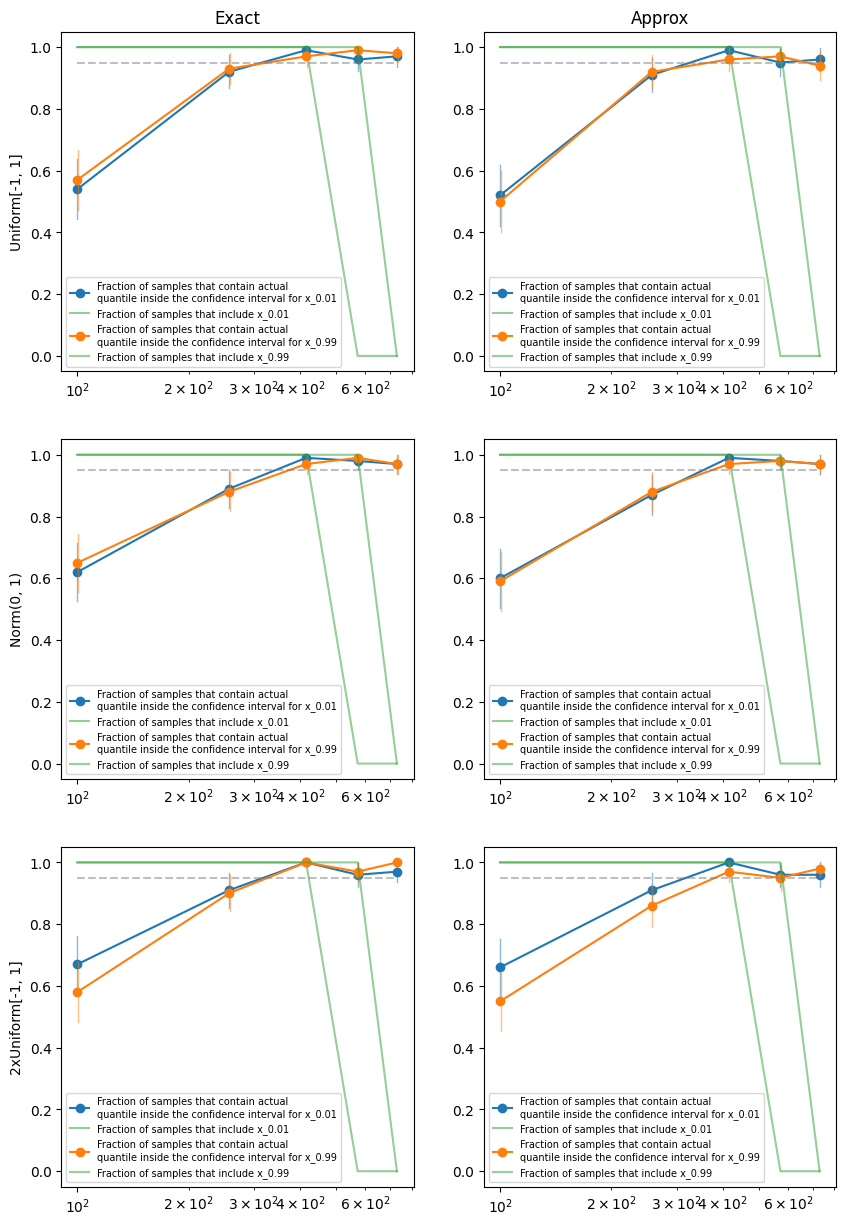

In [84]:
_, axis = plt.subplots(3, NUM_METHODS, figsize=(5 * NUM_METHODS, 5 * len(distros)))
for i, d in enumerate(distros):
    for method_id, method in enumerate(methods):
        for q_id, q in enumerate(QUANTILES):
            for interval_id, interval in enumerate(results[d][q_id][method + "_intervals"]):
                # print(interval_id)
                axis[i][method_id].plot([math.pow(BASE, math.log(NS[interval_id], BASE) + q_id / 400)] * 2, list(interval), color="C" + str(q_id), alpha=.5, linewidth=1)
            axis[i][method_id].plot(NS, results[d][q_id][method + "_points"], '-o', color="C" + str(q_id), alpha=1, label=f'Fraction of samples that contain actual\nquantile inside the confidence interval for x_{q}')
            axis[i][method_id].plot(NS, includes_edges[d][method_id][q_id], color='C2', alpha=0.5, label=f'Fraction of samples that include x_{q}')

        # plot averaged includes edges for both quantiles
        # edges = [np.mean([includes_edges[d][n][q_id] for q_id, q in enumerate(QUANTILES)]) for n in NS]
        # axis[i][method_id].plot(NS, edges, color='C2', alpha=1)

        # plot includes edges for each quantile separately
        # edges = [includes_edges[d][n_id][1] for n_id in range(NS)]
        # axis[i][method_id].plot(NS, edges, color='C3', alpha=0.5)

        axis[i][method_id].plot(NS, [0.95] * len(NS), color='gray', alpha=.5, linestyle='--')
        axis[i][method_id].set_xscale('log')
        axis[i][method_id].set_ylim([-0.05, 1.05])
        axis[i][method_id].legend(prop={'size': 7})
    axis[i][0].set_ylabel(d)

axis[0][0].title.set_text("Exact")
axis[0][1].title.set_text("Approx")
plt.show()